<a href="https://colab.research.google.com/github/yxyyxy93/A2321_python_ML_smote/blob/master/ASSIGNMENT_3_JOSH_HOWARD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# setting up environment
import sys
assert sys.version_info >= (3, 5)

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import pandas as pd

from scipy.stats import norm

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier

np.random.seed(42)

default_data = pd.read_csv("https://s3.amazonaws.com/www.ruxton.ai/bank+defaults.csv")

In [0]:
default_data.head()

,Financial Institution Name,total_assets,defaulter,Failure_Assistance,log_TA,NI_to_TA,Equity_to_TA,NPL_to_TL,REO_to_TA,ALLL_to_TL,core_deposits_to_TA,brokered_deposits_to_TA,liquid_assets_to_TA,loss_provision_to_TL,ROA,NIM,assets_growth,term_spread,stock_mkt_growth,real_gdp_growth,unemployment_rate_change,treasury_yield_3m,bbb_spread,bbb_spread_change,log_TA_plus_1Q,NI_to_TA_plus_1Q,Equity_to_TA_plus_1Q,NPL_to_TL_plus_1Q,REO_to_TA_plus_1Q,ALLL_to_TL_plus_1Q,core_deposits_to_TA_plus_1Q,brokered_deposits_to_TA_plus_1Q,liquid_assets_to_TA_plus_1Q,loss_provision_to_TL_plus_1Q,ROA_plus_1Q,NIM_plus_1Q,assets_growth_plus_1Q,max_total_assets
0,COLORADO NATIONAL BANK,142138,1,FAILURE,-0.048734,-6.505183,-0.759562,0.880756,-0.162301,-0.039358,-1.594099,-0.182975,0.095380,0.003640,-6.505183,-0.554017,0.365436,0.155788,-0.317435,-0.253927,0.859609,0.006692,0.894064,0.417366,-0.069667,-0.367905,-0.795966,2.013862,-0.066290,0.294916,-2.007894,-0.182975,0.106776,0.004823,-0.367905,-0.840312,-0.582232,142138
1,"COMMUNITY BANK, NATIONAL ASSOCIATION",6364903,0,NaN,2.754852,0.143005,0.249275,-0.405931,-0.327268,-0.244766,0.265125,-0.150770,0.229372,-0.003401,0.143005,-0.109970,1.447333,0.897368,-0.132755,0.348841,0.202649,-0.956664,-0.324746,-0.095051,2.767996,0.205816,0.236031,-0.388327,-0.335160,-0.245810,0.283318,-0.156056,0.318976,-0.003057,0.205816,-0.140365,0.003962,8494486
2,"NEXBANK, SSB",784781,0,NaN,1.211269,0.229021,-0.301031,-0.750449,-0.304600,-0.661804,-2.362597,-0.182975,-0.473225,-0.002684,0.229021,-0.783150,1.466905,-0.400396,0.188968,-0.387875,-0.782792,-0.896455,0.081524,0.161157,1.241315,0.470935,-0.242253,-0.809730,-0.374868,-0.673111,-1.386875,-0.182975,-0.630034,-0.003506,0.470935,-0.799310,0.284815,2698563
3,COMMERCE BANK/SHORE NATIONAL ASSOCIATION,2173481,0,NaN,1.962490,0.253469,-0.922810,-0.752942,-0.374868,-0.260532,1.438397,-0.182975,1.850473,-0.002771,0.253469,-0.099539,0.459243,0.433881,1.674053,0.951609,0.531129,-0.354567,-0.189323,-0.863677,2.043363,0.225454,-1.039013,-0.740467,-0.374868,-0.249210,1.427099,-0.182975,2.028526,-0.002819,0.225454,-0.324276,1.091618,2697759
4,CENTENNIAL BANK,241440,1,FAILURE,0.341981,-1.857315,-0.643992,4.583630,10.678175,0.926359,-2.175126,-0.182975,-1.471494,0.041009,-1.857315,-1.160576,1.145982,1.082763,1.685831,-1.928282,3.158971,-0.836245,3.331682,-3.169554,0.315538,-0.945865,-0.677217,4.701457,12.485022,-0.786735,-1.679305,-0.182975,-1.417561,-0.004326,-0.945865,-1.657427,-0.679579,241440


In [0]:
# splitting data into test and train
features = list(default_data.columns.values[4:])

X = default_data[features]
Y = default_data['defaulter']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42, stratify=Y)

# EDA

In [0]:
# INITIAL OVERVIEW OF DATA LOAD
print(X.head())
print(Y.head())

     log_TA  NI_to_TA  ...  assets_growth_plus_1Q  max_total_assets
0 -0.048734 -6.505183  ...              -0.582232            142138
1  2.754852  0.143005  ...               0.003962           8494486
2  1.211269  0.229021  ...               0.284815           2698563
3  1.962490  0.253469  ...               1.091618           2697759
4  0.341981 -1.857315  ...              -0.679579            241440

[5 rows x 34 columns]
0    1
1    0
2    0
3    0
4    1
Name: defaulter, dtype: int64


In [0]:
# Take a look at descriptive summary statistics of each column 
default_data.describe()

,total_assets,defaulter,log_TA,NI_to_TA,Equity_to_TA,NPL_to_TL,REO_to_TA,ALLL_to_TL,core_deposits_to_TA,brokered_deposits_to_TA,liquid_assets_to_TA,loss_provision_to_TL,ROA,NIM,assets_growth,term_spread,stock_mkt_growth,real_gdp_growth,unemployment_rate_change,treasury_yield_3m,bbb_spread,bbb_spread_change,log_TA_plus_1Q,NI_to_TA_plus_1Q,Equity_to_TA_plus_1Q,NPL_to_TL_plus_1Q,REO_to_TA_plus_1Q,ALLL_to_TL_plus_1Q,core_deposits_to_TA_plus_1Q,brokered_deposits_to_TA_plus_1Q,liquid_assets_to_TA_plus_1Q,loss_provision_to_TL_plus_1Q,ROA_plus_1Q,NIM_plus_1Q,assets_growth_plus_1Q,max_total_assets
count,8.700000e+02,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,8.700000e+02
mean,1.313352e+07,0.481609,1.584821,-0.869547,-0.379015,1.556043,1.298955,0.787284,-0.823960,0.260146,-0.466584,0.009045,-0.869547,-0.386967,-0.205208,0.388704,0.136724,-0.199578,0.459769,-0.478377,0.628665,-0.420171,1.586162,-1.115987,-0.477709,1.865542,1.547698,0.930237,-0.773133,0.291014,-0.440946,0.014013,-1.115987,-0.457421,-0.267356,1.934044e+07
std,7.639600e+07,0.499949,1.521800,2.476686,1.045405,2.534257,3.047004,2.801033,1.434373,2.105678,0.895138,0.058432,2.476686,1.498984,1.157331,0.822894,1.221701,1.148861,1.346864,0.711029,1.235701,1.481374,1.534702,2.270516,1.054320,2.845984,3.383322,2.852296,1.436544,2.110155,0.885047,0.034454,2.270516,1.578822,1.284103,1.130711e+08
min,1.027900e+04,0.000000,-1.985778,-51.439048,-2.046963,-0.828664,-0.374868,-1.129467,-5.129210,-0.182975,-1.979460,-1.483912,-51.439048,-6.194351,-9.356461,-1.976253,-2.083478,-2.865922,-1.768233,-0.956664,-0.866439,-3.681972,-2.018190,-19.316688,-2.288598,-0.828664,-0.374868,-1.129467,-5.129210,-0.182975,-1.980064,-0.019260,-19.316688,-8.915473,-15.281245,1.105100e+04
25%,2.378598e+05,0.000000,0.330963,-1.255314,-0.940447,-0.347852,-0.344098,-0.222636,-1.563354,-0.182975,-1.013977,-0.003348,-1.255314,-1.039708,-0.649127,0.155788,-0.510166,-0.722746,-0.454312,-0.896455,-0.189323,-0.863677,0.296101,-1.613585,-1.171856,-0.325760,-0.339910,-0.215307,-1.463861,-0.182975,-0.998821,-0.003262,-1.613585,-1.124063,-0.688477,2.768382e+05
50%,1.603880e+06,0.000000,1.738377,-0.156508,-0.506693,0.620602,-0.048097,0.300897,-0.555864,-0.182975,-0.633484,-0.000408,-0.156508,-0.515601,-0.174421,0.433881,0.067940,-0.119978,0.202649,-0.836245,0.216947,0.161157,1.778205,-0.198886,-0.581536,0.731422,-0.009424,0.386895,-0.498542,-0.182975,-0.604701,-0.000202,-0.198886,-0.572430,-0.214268,2.901754e+06
75%,4.825205e+06,1.000000,2.550619,0.111030,-0.090618,2.870976,1.480966,1.266340,0.193063,-0.182975,-0.116276,0.012220,0.111030,0.011653,0.190574,1.082763,1.644237,0.834404,0.859609,-0.053518,0.894064,0.417366,2.573069,0.118585,-0.110107,3.519071,1.949759,1.561332,0.266801,-0.182975,-0.042141,0.015643,0.118585,-0.103784,0.170400,7.685961e+06
max,1.606232e+09,1.000000,6.833548,4.270392,12.806670,27.234734,23.316201,70.718118,1.892051,26.368548,4.056425,0.264265,4.270392,18.118218,9.147865,1.268158,1.685831,1.487403,3.158971,1.873195,3.331682,1.698409,6.838213,7.563480,12.873529,27.234734,25.542604,70.718118,1.926861,26.602784,4.073650,0.400951,7.563480,14.834582,11.055260,2.096114e+09


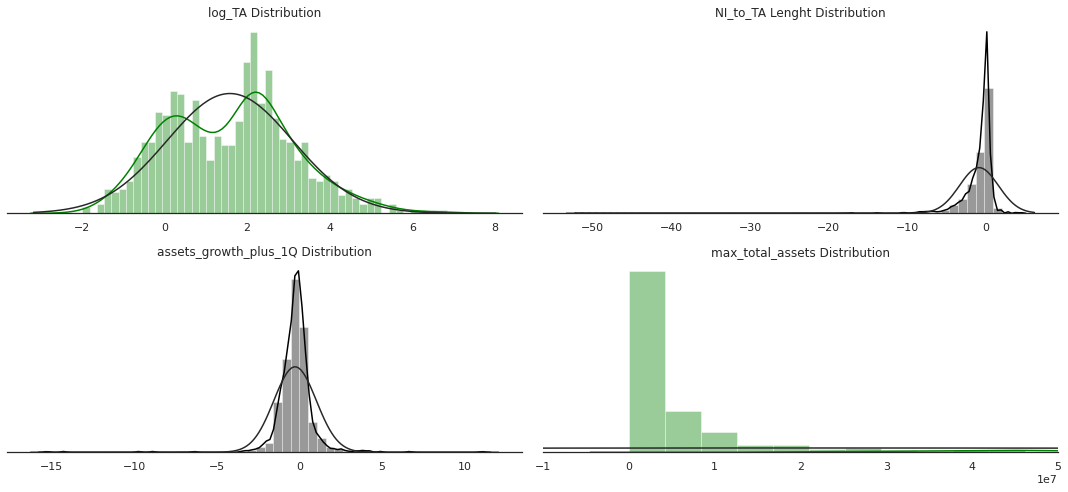

In [0]:
# PLOTTING log_TA, NI_to_TA, assets_growth_plus_1Q, max_total_assets DISTRIBUTION  
sns.set(style="white", palette="muted", color_codes=True)
rs = np.random.RandomState(10)

f, axes = plt.subplots(2, 2, figsize=(15, 7))
sns.despine(left=True)

sns.distplot(X['log_TA'], bins=50, fit=norm, ax=axes[0, 0], color = "green")
sns.distplot(X["NI_to_TA"], bins=50,fit=norm, ax=axes[0, 1], color = "black")
sns.distplot(X["assets_growth_plus_1Q"], bins=50,fit=norm, ax=axes[1, 0], color = "black")
sns.distplot(X["max_total_assets"], bins=500, fit=norm, ax=axes[1, 1], color = "green")

# axes[0,0].set_xlim(10, 100)
axes[1,1].set_xlim(-1e7, 5e7)

axes[0,0].set_title("log_TA Distribution")
axes[0,1].set_title("NI_to_TA Lenght Distribution")
axes[1,0].set_title("assets_growth_plus_1Q Distribution")
axes[1,1].set_title("max_total_assets Distribution")

axes[0,0].set_xlabel('')
axes[0,1].set_xlabel('')
axes[1,0].set_xlabel('')
axes[1,1].set_xlabel('')

plt.setp(axes, yticks=[])
plt.tight_layout()

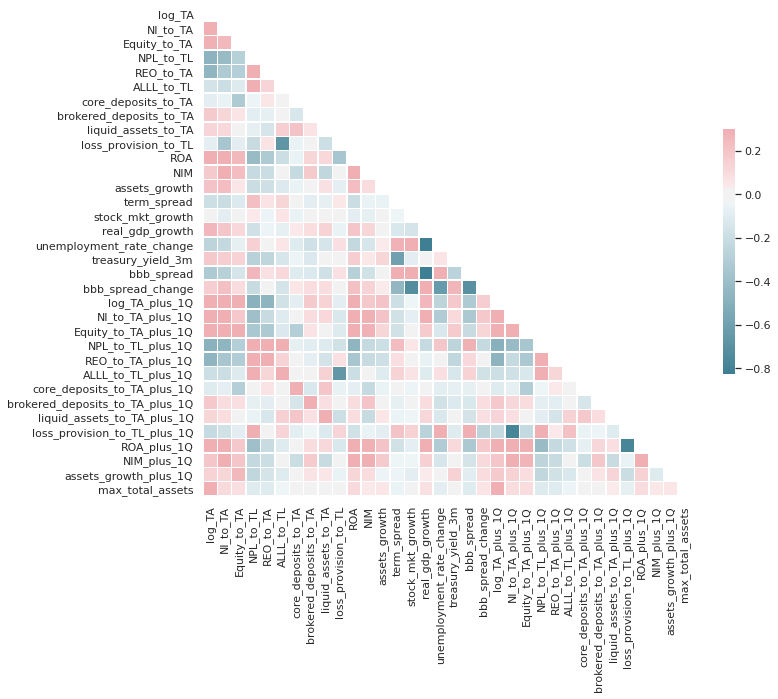

In [0]:
# Compute the correlation matrix
corr = X_train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [0]:
# Checking the missing values
X.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   log_TA                           870 non-null    float64
 1   NI_to_TA                         870 non-null    float64
 2   Equity_to_TA                     870 non-null    float64
 3   NPL_to_TL                        870 non-null    float64
 4   REO_to_TA                        870 non-null    float64
 5   ALLL_to_TL                       870 non-null    float64
 6   core_deposits_to_TA              870 non-null    float64
 7   brokered_deposits_to_TA          870 non-null    float64
 8   liquid_assets_to_TA              870 non-null    float64
 9   loss_provision_to_TL             870 non-null    float64
 10  ROA                              870 non-null    float64
 11  NIM                              870 non-null    float64
 12  assets_growth         

0    451
1    419
Name: defaulter, dtype: int64
Proportion: 1.08 : 1


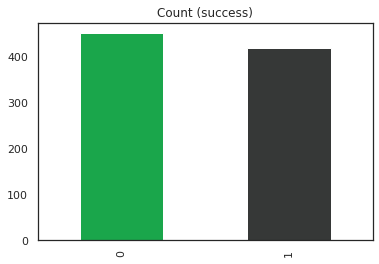

In [0]:
# class inbalance
success_count = Y.value_counts()
print(success_count)
print('Proportion:', round(success_count[0] / success_count[1], 2), ': 1')

success_count.plot(kind='bar', title='Count (success)', color=["#1aa64b","#363837"]);

In [0]:
# applying decision tree

from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

grid_search_cv.fit(X, Y)


Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 882 out of 882 | elapsed:    9.6s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,


In [0]:
# assessing decision tree accuracy

from sklearn import metrics
from statistics import mean
Y_pred = grid_search_cv.predict(X_test)
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))

Accuracy: 0.9693486590038314


In [0]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_pred,Y_test))

[[133   6]
 [  2 120]]


In [0]:
# applying random forest

from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train, Y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
# assessing random forest accuracy

from sklearn import metrics

Y_pred_forest=forest.predict(X_test)
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred_forest))

Accuracy: 0.9540229885057471


In [0]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_pred_forest,Y_test))

[[133  10]
 [  2 116]]


In [0]:
# applying logistic regression model

from xgboost import XGBClassifier
log_model = XGBClassifier()
log_model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
from sklearn import metrics

Y_pred_log_model=log_model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred_log_model))

Accuracy: 0.9540229885057471


In [0]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_pred_log_model,Y_test))

[[133  10]
 [  2 116]]
